In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import utils.spike_utils as spike_utils
import utils.classifier_utils as classifier_utils
import utils.visualization_utils as visualization_utils

import os
import pandas as pd
import matplotlib

In [8]:
PRE_INTERVAL = 1300
POST_INTERVAL = 1500
INTERVAL_SIZE = 50
EVENT = "FeedbackOnset"
N_BLOCKS_OF_RULE = 5

# output dir that was specified in the decode_features_with_pseudo.py
OUTPUT_DIR = "/data/patrick_scratch/pseudo"

SESSIONS_PATH = f"/data/patrick_scratch/multi_sess/valid_sessions_more_than_{N_BLOCKS_OF_RULE}_of_rule.pickle"

DECODING_NAME = "is_rule_or_not_last_8_cors"

SMOOTH = 2

DATA_MODE = "FiringRate"

WEIGHT_DECAY = 0.2

In [9]:
def plot_decoder_accuracy(feature, ax):
    # plots the mean and standard deviation of decoding accuracy across splits, by time. 
    if ax is None: 
        fig, ax = plt.subplots()
    # load the test accuracy of generated from the decode_features_with_pseudo.py script
    # here I'm just visualizing test accuracy, but can very well visualize train/shuffled as well. 

    test_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature}_{DECODING_NAME}_{DATA_MODE}_smooth_{SMOOTH}_reg_{WEIGHT_DECAY}_test_accs.npy"))
    train_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature}_{DECODING_NAME}_{DATA_MODE}_smooth_{SMOOTH}_reg_{WEIGHT_DECAY}_train_accs.npy"))
    shuffled_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature}_{DECODING_NAME}_{DATA_MODE}_smooth_{SMOOTH}_reg_{WEIGHT_DECAY}_shuffled_accs.npy"))

    # test_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature}_{DECODING_NAME}_test_accs.npy"))
    # train_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature}_{DECODING_NAME}_train_accs.npy"))
    # shuffled_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature}_{DECODING_NAME}_shuffled_accs.npy"))
    visualization_utils.visualize_accuracy_across_time_bins(
        test_accs,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"{feature} is rule vs. not",
        right_align=True, 
        sem=False
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        shuffled_accs,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"Shuffled accuracy",
        right_align=True, 
        sem=False
    )
    # visualization_utils.visualize_accuracy_across_time_bins(
    #     train_accs,
    #     PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    #     ax,
    #     label=f"Train accuracy",
    #     right_align=True, 
    #     sem=False
    # )
    ax.legend()
    # add grey band for selection period
    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    # add dotted line for feedback start
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    # add estimated chance
    ax.axhline(0.5, color='black', linestyle='dotted', label="Estimated Chance")
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.set_ylabel("Decoder Accuracy")

def plot_weights(feature, ax):
    valid_sess = pd.read_pickle(SESSIONS_PATH)
    valid_sess = valid_sess[valid_sess[feature]]
    fr_path = "/data/patrick_scratch/multi_sess/{{session}}/{{session}}_firing_rates_{pre_interval}_{event}_{post_interval}_{interval_size}_bins_{smooth}_smooth.pickle".format(
        pre_interval=PRE_INTERVAL,
        event=EVENT,
        post_interval=POST_INTERVAL,
        interval_size=INTERVAL_SIZE,
        smooth=SMOOTH
    )
    # fr_path = "/data/patrick_scratch/multi_sess/{{session}}/{{session}}_firing_rates_{pre_interval}_{event}_{post_interval}_{interval_size}_bins.pickle".format(
    #     pre_interval=PRE_INTERVAL,
    #     event=EVENT,
    #     post_interval=POST_INTERVAL,
    #     interval_size=INTERVAL_SIZE,
    # )
    positions = spike_utils.get_unit_positions(valid_sess, fr_path)
    models = np.load(os.path.join(OUTPUT_DIR, f"{feature}_{DECODING_NAME}_{DATA_MODE}_smooth_{SMOOTH}_reg_{WEIGHT_DECAY}_models.npy"), allow_pickle=True)
    # models = np.load(os.path.join(OUTPUT_DIR, f"{feature}_{DECODING_NAME}_models.npy"), allow_pickle=True)
    weights = classifier_utils.evaluate_model_weights_by_time_bins(models, num_neurons=len(models[0, 0].coef_[0]), num_classes=2)
    positions = positions[positions.manual_structure != "unknown"]
    # evaluate weights by time. Pass in number of neurons and number of classes
    # normalize weights so that they sum to 1
    sums = np.sum(weights, axis=0)
    normalized = weights / sums
    means = np.mean(normalized, axis=1)
    means_df = pd.DataFrame({'np_idx': np.arange(len(means)), 'weight': means})
    if ax is None: 
        fig, ax = plt.subplots(sharex=True)
    visualization_utils.visualize_weights(
        positions, 
        normalized, 
        "manual_structure", 
        interval_size=INTERVAL_SIZE,
        name_to_color=visualization_utils.REGION_TO_COLOR, 
        mean_weights_df=means_df,
        ax=ax
    )

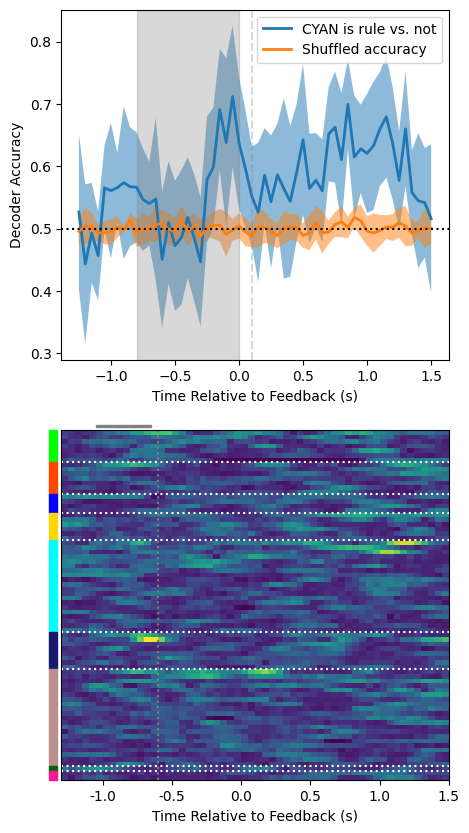

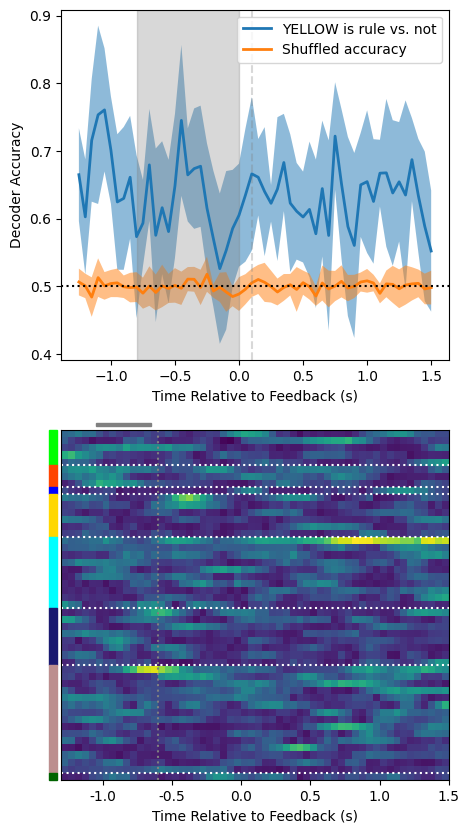

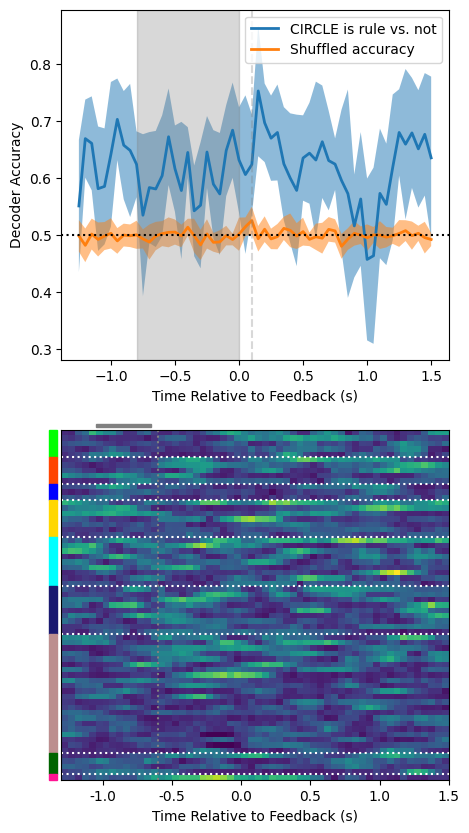

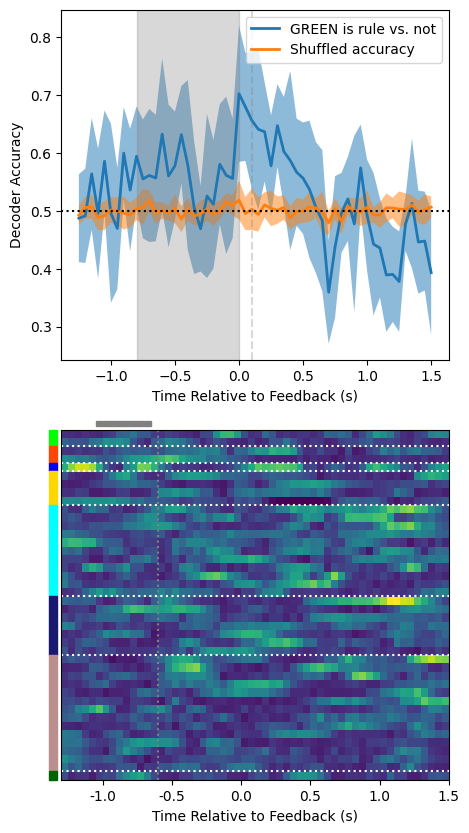

In [10]:
FEATURES = ["CYAN", "YELLOW", "CIRCLE", "GREEN"]
# FEATURES = ["CYAN", "YELLOW"]

for feature in FEATURES:
    fig, axs = plt.subplots(2, 1, figsize=(5, 10))
    plot_decoder_accuracy(feature, axs[0])
    plot_weights(feature, axs[1])

    # fig, ax = plt.subplots()
    # plot_decoder_accuracy(feature, ax)


### average decoding accuracies across all 5 features?

Text(0, 0.5, 'Decoder Accuracy')

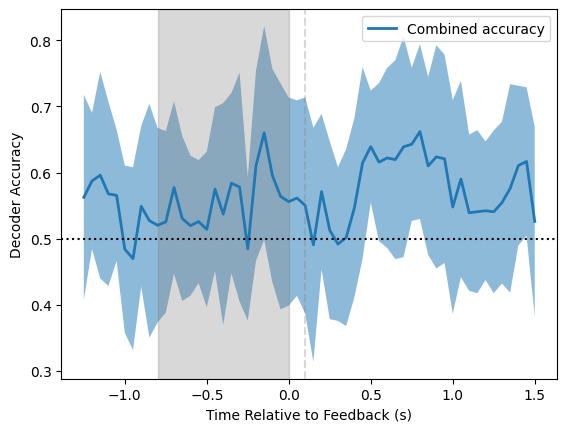

In [11]:
combined = []
FEATURES = ["TRIANGLE", "CYAN"]
for feature in FEATURES:
    test_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature}_{DECODING_NAME}_{DATA_MODE}_smooth_{SMOOTH}_reg_{WEIGHT_DECAY}_test_accs.npy"))
    combined.append(test_accs)
combined = np.hstack(combined)
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    combined,
    PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
    ax,
    label=f"Combined accuracy",
    right_align=True, 
    sem=False
)
ax.legend()
# add grey band for selection period
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
# add dotted line for feedback start
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
# add estimated chance
ax.axhline(0.5, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Decoder Accuracy")

(28, 50)